# Image Classification via Neural Networks: Dogs vs Cats

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, shutil

from keras.datasets import imdb
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# 1. Data
## 1. Creating the Data
From the original Kaggle dataset consisting of 50,000 images, we use create a new training set of 1,000 samples each for dogs and cats, a validation set with 500 each and a test set with 500 each.

In [2]:
original_dataset_dir = '/home/d869321/Data/CatsVsDogs'
base_dir = '/home/d869321/Data/CatsVsDogsSmall'
os.mkdir(base_dir)

# create directories for the training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

As a sanity check, let us count how many pictures are in each directory.

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 1.1. Data Manipulation
We need to convert all the jpegs into tensors.

In [4]:
# these three lines are repeated incase you don't want to reconstruct the small Images folder
base_dir = '/home/d869321/Data/CatsVsDogsSmall'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1./255)  # rescale images by 1/255 so the values lie in [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)

# 2nd argument = resolution of image (incl. deformation), 4th argument = 'binary' refers to labels
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                    batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), 
                                                        batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The generators yield batches of 150x150 RCB images (i.e. shape (20, 150, 150, 3)) and binary labels (shape (20,)). If the input images are not square, they will be deformed to align with the 150x150 specification.

In [5]:
from IPython.display import display
from PIL import Image

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


We can display a sample of such pictures and their labels.

label: 0.0
the 0-th image is:


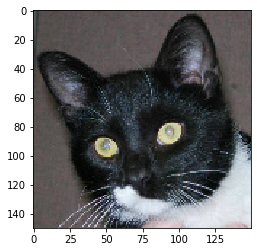

label: 0.0
the 0-th image is:


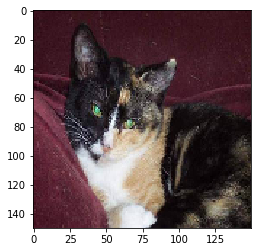

label: 1.0
the 0-th image is:


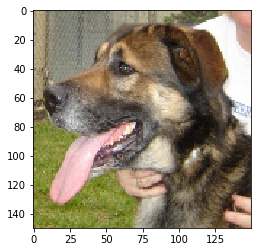

label: 0.0
the 0-th image is:


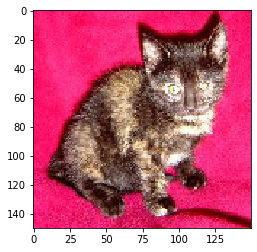

In [6]:
ind = 0
i = 0
for data_batch, labels_batch in train_generator:
    print('label:', labels_batch[ind])
    print('the %s-th image is:'%ind)
    imagePet = data_batch[ind]
    plt.imshow(imagePet)
    plt.show()
    i += 1
    if i > 3:
        break

# 2. Building Network Architecture
The CNN will be a stack of alternated Conv2D and MaxPooling2D layers. The depth of the feature maps will increase with each layer whilst the size of the feature maps will decrease.

As this is a binary classification problem, we end with a densely connected layer with a single unit and a sigmoid acitvation.

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

We can get the network architecture.

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

As we need a binary classifier, we use binary crossentropy as our loss.

In [9]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

# 3. Model Fitting
We can fit the model using the training generator defined earlier. The model accuracy can be validated using the validation generator.

In [10]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, 
                              validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 26s 262ms/step - loss: 0.6917 - acc: 0.5395 - val_loss: 0.6957 - val_acc: 0.6230
Epoch 2/30
100/100 [==============================] - 26s 261ms/step - loss: 0.6621 - acc: 0.6045 - val_loss: 0.5736 - val_acc: 0.6320
Epoch 3/30
100/100 [==============================] - 26s 261ms/step - loss: 0.6178 - acc: 0.6600 - val_loss: 0.6198 - val_acc: 0.6610
Epoch 4/30
100/100 [==============================] - 27s 268ms/step - loss: 0.5772 - acc: 0.7040 - val_loss: 0.4695 - val_acc: 0.6260
Epoch 5/30
100/100 [==============================] - 27s 266ms/step - loss: 0.5401 - acc: 0.7220 - val_loss: 0.5901 - val_acc: 0.6870
Epoch 6/30
100/100 [==============================] - 26s 264ms/step - loss: 0.5259 - acc: 0.7385 - val_loss: 0.5045 - val_acc: 0.6930
Epoch 7/30
100/100 [==============================] - 26s 264ms/step - loss: 0.4962 - acc: 0.7565 - val_loss: 0.5273 - val_acc: 0.6830
Epoch 8/30
100/100 [==============================] - 2

In [11]:
model.save('cats_and_dogs_small_1.h5')

# 4. Model Evaluation
As before, we can evaluate the model on the validation sets.

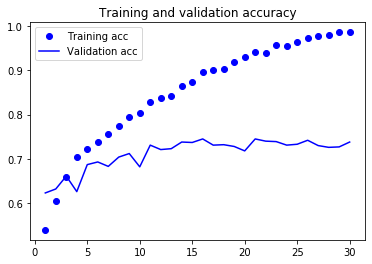

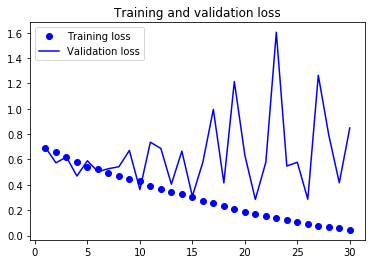

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The network starts overfit after ~15 epochs.

# 5. Data Augmentation
We apply various random transformations to the images to create new images to use for training:
- rotation of image
- translate images (both horizontally and vertically)
- shear image
- zoom in or out
- horizontal flips can be performed if symmetry is assumed

We will need to specify how an empty regions created by such transformations are filled. One possibility is to fill it with values of the nearest pixel.

In [13]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                            shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

We can have a look at the augmented images look like.

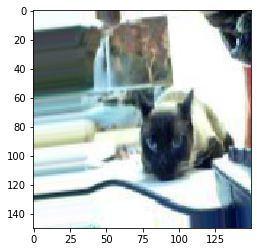

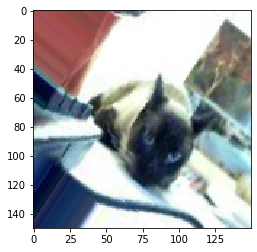

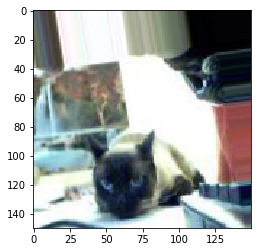

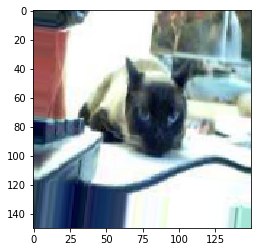

In [14]:
from keras.preprocessing import image

base_dir = '/home/d869321/Data/CatsVsDogsSmall'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[5]  # choose one image to augment
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)  # convert to numpy array
x = x.reshape((1,) + x.shape)  # reshape to (1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        

We can then fit a neural network using the augmented data. We start by defining a CNN with dropout in the final convolutional layer.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Let us now create the augmented dataset to use for training. We shouldn't augment the test dataset.

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                   batch_size=32, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                       batch_size=32, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We can then fit the model on the augmented data and subsequently validate it on the data in the validation directory.

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                             validation_data=validation_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 42s 420ms/step - loss: 0.6943 - acc: 0.5060 - val_loss: 0.6950 - val_acc: 0.5641
Epoch 2/100
100/100 [==============================] - 42s 419ms/step - loss: 0.6807 - acc: 0.5590 - val_loss: 0.6460 - val_acc: 0.5979
Epoch 3/100
100/100 [==============================] - 42s 424ms/step - loss: 0.6656 - acc: 0.5927 - val_loss: 0.6775 - val_acc: 0.6129
Epoch 4/100
100/100 [==============================] - 42s 423ms/step - loss: 0.6559 - acc: 0.6082 - val_loss: 0.6509 - val_acc: 0.6488
Epoch 5/100
100/100 [==============================] - 42s 424ms/step - loss: 0.6387 - acc: 0.6316 - val_loss: 0.7874 - val_acc: 0.5920
Epoch 6/100
100/100 [==============================] - 43s 429ms/step - loss: 0.6239 - acc: 0.6486 - val_loss: 0.5628 - val_acc: 0.6733
Epoch 7/100
100/100 [==============================] - 43s 426ms/step - loss: 0.6155 - acc: 0.6638 - val_loss: 0.5185 - val_acc: 0.6942
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 43s 435ms/step - loss: 0.4147 - acc: 0.8078 - val_loss: 0.4718 - val_acc: 0.7854
Epoch 62/100
100/100 [==============================] - 44s 440ms/step - loss: 0.4248 - acc: 0.7968 - val_loss: 0.4209 - val_acc: 0.7468
Epoch 63/100
100/100 [==============================] - 43s 427ms/step - loss: 0.4159 - acc: 0.8087 - val_loss: 0.5651 - val_acc: 0.7326
Epoch 64/100
100/100 [==============================] - 43s 426ms/step - loss: 0.4101 - acc: 0.8059 - val_loss: 0.8502 - val_acc: 0.7390
Epoch 65/100
100/100 [==============================] - 43s 428ms/step - loss: 0.4066 - acc: 0.8138 - val_loss: 0.5222 - val_acc: 0.8090
Epoch 66/100
100/100 [==============================] - 43s 428ms/step - loss: 0.4142 - acc: 0.8043 - val_loss: 0.5173 - val_acc: 0.8054
Epoch 67/100
100/100 [==============================] - 43s 429ms/step - loss: 0.4037 - acc: 0.8197 - val_loss: 0.4038 - val_acc: 0.7824
Epoch 68/100
100/100 [===================

In [18]:
model.save('cats_and_dogs_small_2.h5')

We can again replot the loss and accuracy over both the training and validation datasets.

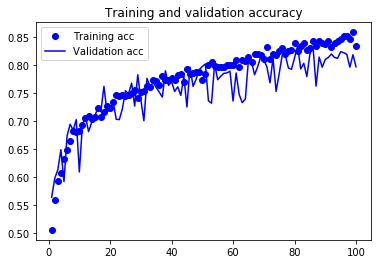

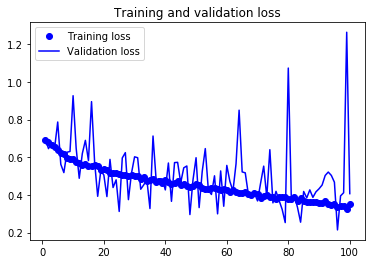

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

Thanks to data augmentation and dropout, we'e boosted the model accuracy to ~80%.

# 6. Leveraging a Pretrained Model
It is often helpful to use a pretrained network that was trained on a large scale image-classifcation task. If the dataset is large and general enough, then the spatial hierarchy of features learned by the pretrained network can be useful in the visual world. There are two ways to use the features.
## 6.1. Feature Extraction
Every convolutional neural network consists of a convolutional base and a classifier. We can choose to freeze the convolutional base and retrain the classifier part on a new image processing task. We shall use the VGG16 model.

In [20]:
from keras.applications import VGG16

# 1st argument is the weight checkpoint from which to initialize the model
# 2nd argument is whether or not to include the densely connecected classifer
# 3rd argument is input shape of image tensors. If not passed, network will be able to process any input
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

We need to know the input to feed into the classifier so let's have a look at the neural network shape.

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Note the final convolutional layer has shape `(4, 4, 512)`. We can proceed in one of two ways:
- run the convolutional base over the 2000 images to produce the `(4, 4, 512)` output for each image. This can then be used as input for a standalone, densely connected classifer. This solution is computationally cheap, but it does not allow us to use data augmentation.
- extend the convolational base model by adding dense layers on top and run the whole thing end to end on the input data. This will allow us to use data augmentation but will be very expensive.

### 6.1.1. Fast Feature Extraction without Data Augmentation
We start by running instances of `ImageDataGenerator` to extract images as Numpy arrays and their corresponding labels. We can subsequently extract features from these images by calling the predict method of the `conv_base` model.

In [22]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))  # dimension of final convolutional layer
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), 
                                            batch_size=batch_size, class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)  # convolutional base output for the i-th batch
        features[(i * batch_size) : ((i + 1) * batch_size)] = features_batch
        labels[(i * batch_size) : ((i + 1) * batch_size)] = labels_batch
        i += 1
        if (i * batch_size) >= sample_count:
            break
    
    return features, labels

test_dir = os.path.join(base_dir, 'test')

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# need to flatten features from (samples, 4, 4, 512) to (samples, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We can now define a densely-connected classifier to train the data on. We shall use dropout on the first layer.

In [23]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=(4 * 4 * 512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 677us/step - loss: 0.5809 - acc: 0.6895 - val_loss: 0.4235 - val_acc: 0.8480
Epoch 2/30
2000/2000 [==============================] - 1s 641us/step - loss: 0.4132 - acc: 0.8195 - val_loss: 0.3509 - val_acc: 0.8690
Epoch 3/30
2000/2000 [==============================] - 1s 645us/step - loss: 0.3473 - acc: 0.8565 - val_loss: 0.3360 - val_acc: 0.8590
Epoch 4/30
2000/2000 [==============================] - 1s 625us/step - loss: 0.3064 - acc: 0.8725 - val_loss: 0.2945 - val_acc: 0.8900
Epoch 5/30
2000/2000 [==============================] - 1s 622us/step - loss: 0.2833 - acc: 0.8900 - val_loss: 0.2807 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 1s 630us/step - loss: 0.2588 - acc: 0.8955 - val_loss: 0.2810 - val_acc: 0.8820
Epoch 7/30
2000/2000 [==============================] - 1s 630us/step - loss: 0.2503 - acc: 0.8990 - val_loss: 0.2619 - val_acc: 0.8970


Lets plot the performance of the model.

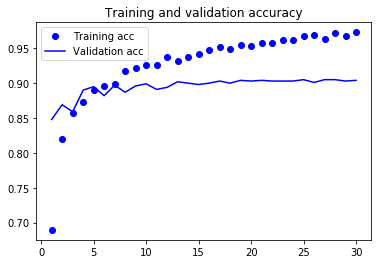

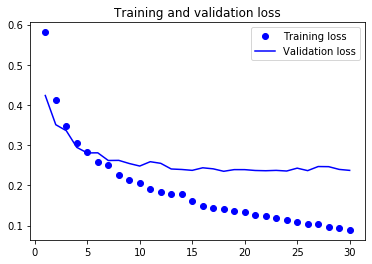

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

We reach an accuracy of ~90% on the validated dataset. We can check if we can improve this still further by allowing for data augmentation.
### 6.1.2. Feature Extraction with Data Augmentation
Here, we simply extend the convolutional base model with a classifier.

In [25]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

The model architecture is as follows:

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


We need to freeze the convolutional base to ensure that the representation does not get destroyed whilst updating the randomly-initialized weights of the classifier.

In [27]:
print('This is the number of trainable weights before freezing the conv base', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base 30
This is the number of trainable weights after freezing the conv base 4


The 4 trainable weights refers to the main weight matrix and the bias vectors for each of the two layers.

In order for these changes to take effect, we compile the model.

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, 
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

# the test dataset should NOT be augmented!!!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                    batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                       batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, 
                              validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 158s 2s/step - loss: 0.6100 - acc: 0.6645 - val_loss: 0.5518 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 154s 2s/step - loss: 0.4836 - acc: 0.7910 - val_loss: 0.4166 - val_acc: 0.8410
Epoch 3/30
100/100 [==============================] - 155s 2s/step - loss: 0.4469 - acc: 0.7995 - val_loss: 0.1546 - val_acc: 0.8680
Epoch 4/30
100/100 [==============================] - 154s 2s/step - loss: 0.4084 - acc: 0.8170 - val_loss: 0.1767 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 154s 2s/step - loss: 0.3855 - acc: 0.8255 - val_loss: 0.3572 - val_acc: 0.8800
Epoch 6/30
100/100 [==============================] - 154s 2s/step - loss: 0.3777 - acc: 0.8250 - val_loss: 0.4798 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 154s 2s/step - loss: 0.3532 - acc: 0.8525 - val_loss: 0.2043 - v

Let's check the performance of the model.

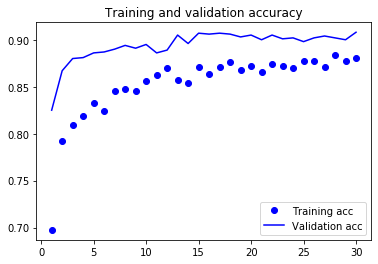

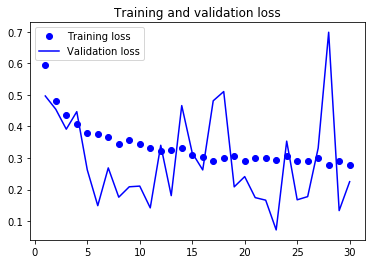

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The accuracy is still ~90%.

## 6.2. Fine Tuning
The second way to use a pre-trained model was for fine-tuning. This consists of unfreezing a few of the top layers of the convolutional base and jointly training these layers in addition to the the fully-connected classifier on top. This allows slight adjustment to the more abstract representations of the model in order to make them more relevant to the problem at hand. We choose to unfreeze the layers after the penultimate `MaxPooling2D` layer.

In order to avoid destroying these higher-level abstractions, we start by initially freezing the whole convolutional base and train the classifier part. Once the classifier is trained, we can unfreeze the top layers of the Convolutional base and update it and the classifier.

Here is the current convolutional base:

In [29]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will make all layers up to `block4_pool` frozen and layers `block5_conv1`, `block5_conv2`, `block5_conv3` will be trainable.

In [30]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In training the model, we use a very low learning rate as we want to limit the modifications made to the representations.

In [31]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                             validation_data=validation_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 177s 2s/step - loss: 0.2919 - acc: 0.8700 - val_loss: 0.2097 - val_acc: 0.8980
Epoch 2/100
100/100 [==============================] - 175s 2s/step - loss: 0.2497 - acc: 0.8970 - val_loss: 0.1153 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 175s 2s/step - loss: 0.2464 - acc: 0.8965 - val_loss: 0.0415 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 175s 2s/step - loss: 0.2285 - acc: 0.9020 - val_loss: 0.0196 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 175s 2s/step - loss: 0.2056 - acc: 0.9225 - val_loss: 0.0044 - val_acc: 0.9260
Epoch 6/100
100/100 [==============================] - 176s 2s/step - loss: 0.1909 - acc: 0.9145 - val_loss: 0.2757 - val_acc: 0.9250
Epoch 7/100
100/100 [==============================] - 178s 2s/step - loss: 0.1769 - acc: 0.9290 - val_loss: 0.0189 - val_acc: 0.9260
Epoch 8/100
100/100 [==============================] - 176s 2s

Epoch 62/100
100/100 [==============================] - 176s 2s/step - loss: 0.0284 - acc: 0.9885 - val_loss: 0.0448 - val_acc: 0.9400
Epoch 63/100
100/100 [==============================] - 176s 2s/step - loss: 0.0259 - acc: 0.9900 - val_loss: 0.0022 - val_acc: 0.9390
Epoch 64/100
100/100 [==============================] - 176s 2s/step - loss: 0.0316 - acc: 0.9905 - val_loss: 0.1989 - val_acc: 0.9400
Epoch 65/100
100/100 [==============================] - 176s 2s/step - loss: 0.0268 - acc: 0.9910 - val_loss: 0.0010 - val_acc: 0.9370
Epoch 66/100
100/100 [==============================] - 176s 2s/step - loss: 0.0262 - acc: 0.9880 - val_loss: 0.7435 - val_acc: 0.9370
Epoch 67/100
100/100 [==============================] - 176s 2s/step - loss: 0.0496 - acc: 0.9860 - val_loss: 0.1559 - val_acc: 0.9450
Epoch 68/100
100/100 [==============================] - 176s 2s/step - loss: 0.0278 - acc: 0.9895 - val_loss: 0.0035 - val_acc: 0.9440
Epoch 69/100
100/100 [==============================] -

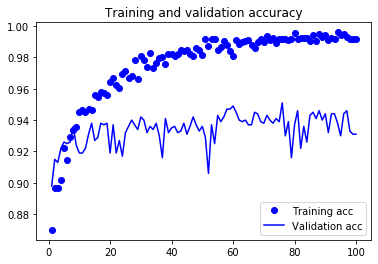

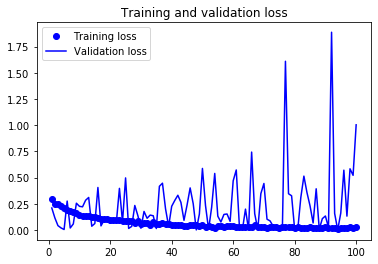

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

The curves are quite noisy so lets plot an exponentially-smoothed version.

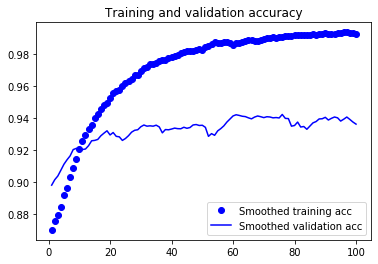

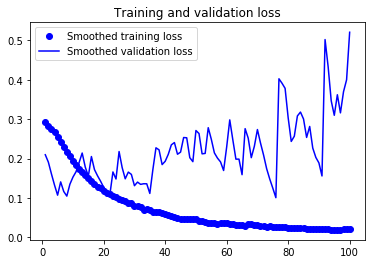

In [33]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

The accuracy of the model appears to top out at ~94%. The Exponentially weighted moving average of the loss function is increasing, which is paradoxical as the accuracy is improving. It appears accuracy relies more on the distribution of the loss values rather than their average.

Let's looks at the performance of the model on the test data.

In [34]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), 
                                                  batch_size=20, class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9380000233650208


In [35]:
model.save('cats_and_dogs_pretrain.h5')

The model achieves 94% performance on the test data.

# 7. Visualizing the Covnets
We can visualize the models in three ways:
1. Visualize intermidiate covnet outputs (intermediate activations)
2. Visualize the covnet filters
3. Visualize heatmaps of class activation in an image

## 7.1. Visualize intermiediate activations

In [36]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

We then select an input image to visualize.

(1, 150, 150, 3)


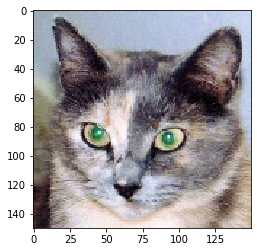

In [37]:
img_path = test_dir + '/cats/cat.1700.jpg'

from keras.preprocessing import image

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

plt.imshow(img_tensor[0])

In order to extract the feature maps, we create a model that takes batches of images as input and outputs the activations of all convolutional and pooling layers.

In [38]:
layer_outputs = [layer.output for layer in model.layers[:8]]  # extract output of first eight layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

This model has one input and eight outputs: one output per layer activation. Let's plot the fourth and seventh channels of the first layer's activation.

(1, 148, 148, 32)


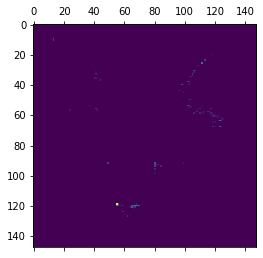

<Figure size 432x288 with 0 Axes>

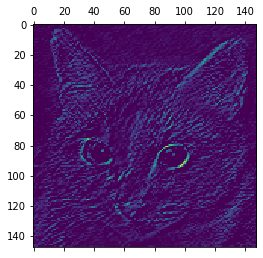

In [39]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.figure()
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

Let's extract and plot every channel in each of the eight activation maps.

/home/d869321/anaconda3/envs/neural/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


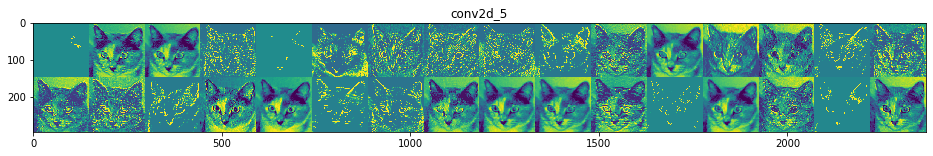

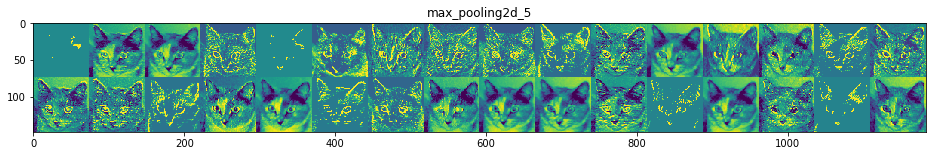

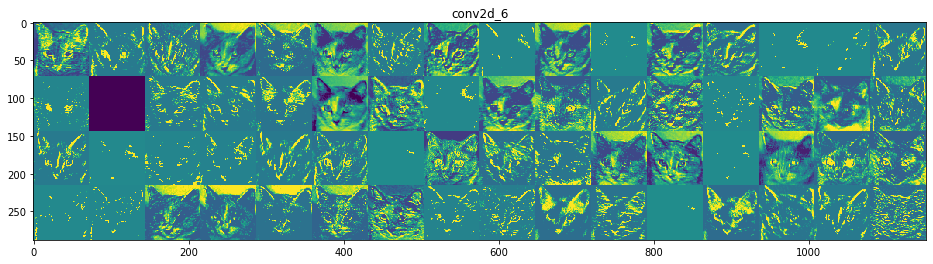

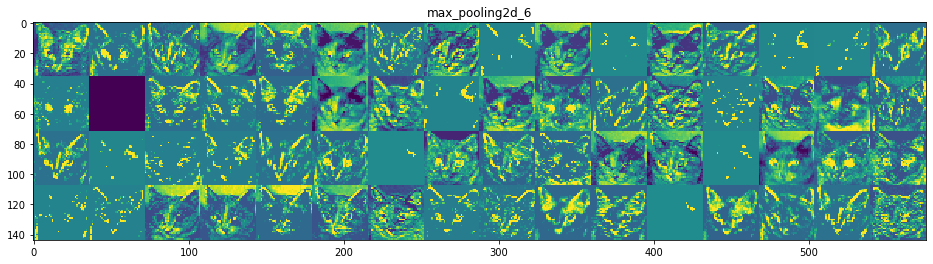

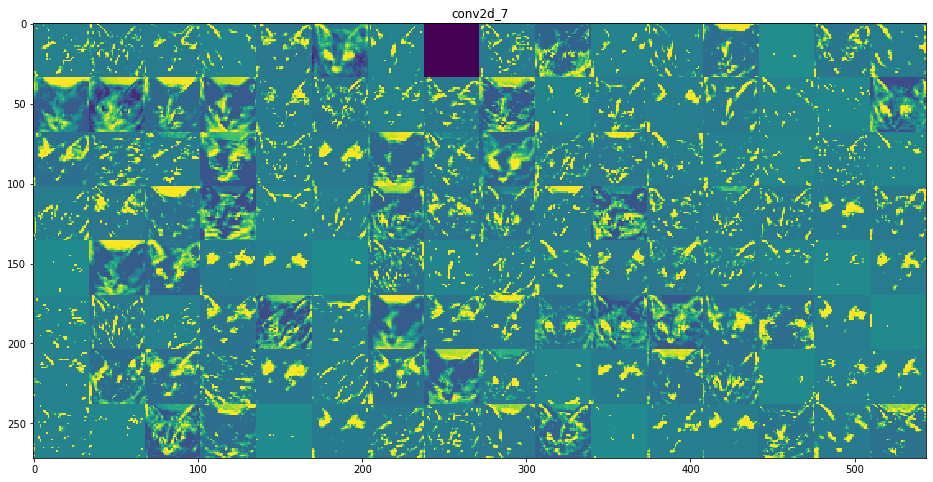

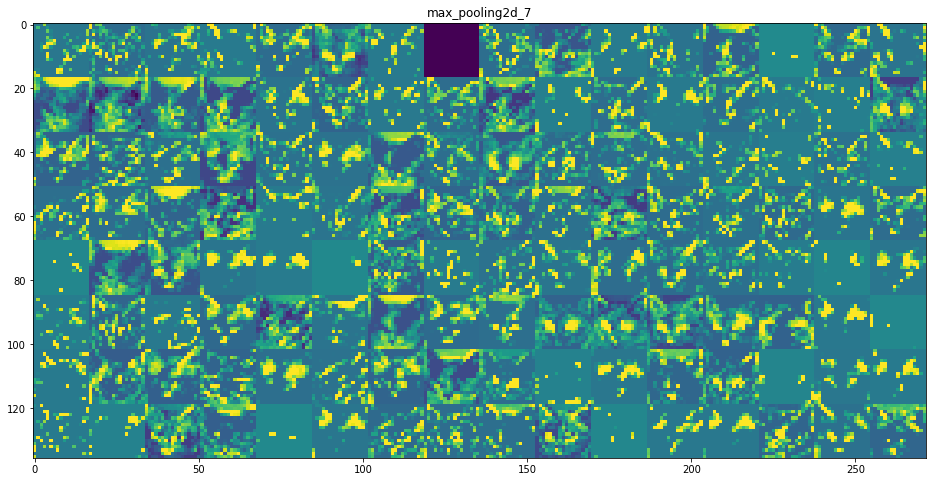

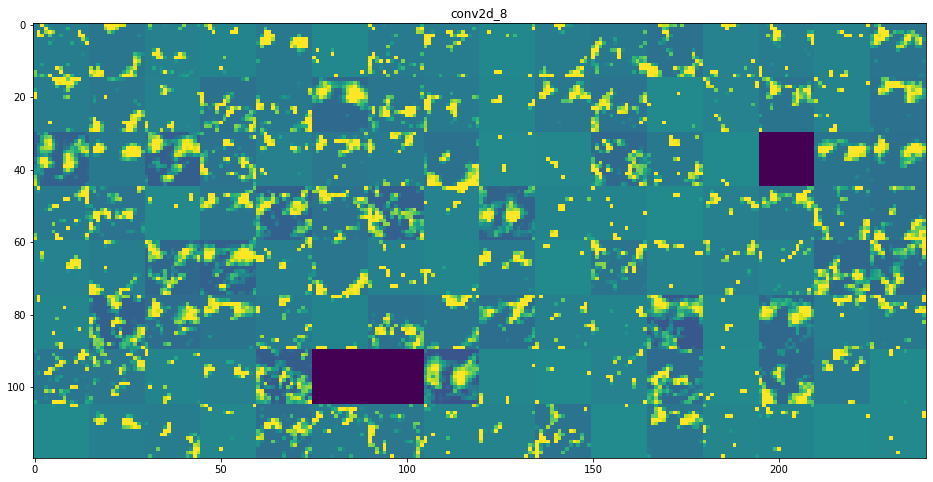

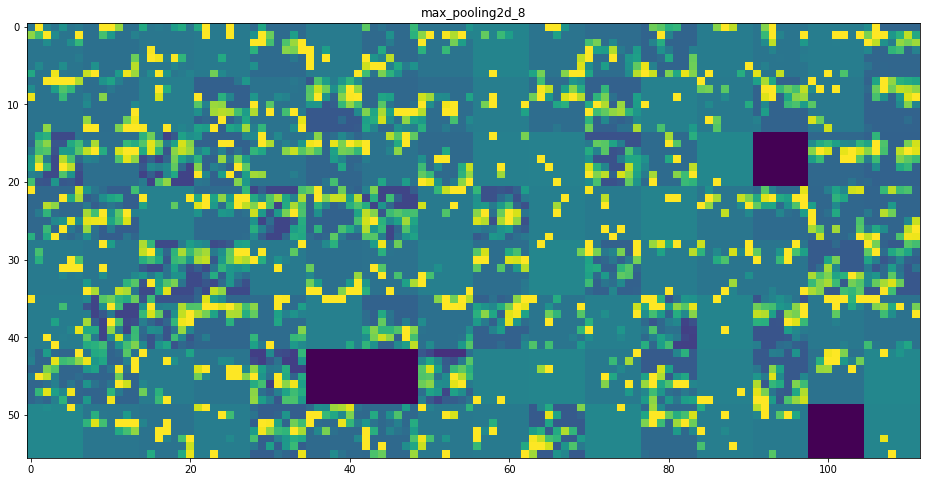

In [40]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # i.e. the number of channels in a layer
    
    size = layer_activation.shape[1]  # shape is (n, size, size, n_features / n_channels)
    
    n_rows = n_features // images_per_row
    display_grid = np.zeros((size * n_rows, images_per_row * size))
    
    for row in range(n_rows):
        for col in range(images_per_row):
            channel_image = layer_activation[0, :, :, row * images_per_row + col]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[(row * size):((row + 1) * size), (col * size):((col + 1) * size)] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap='viridis')

The first layer acts as a collection of edge detectors. As we go deeper, the activations carry less and less visual information about the input and more and more information about the target. Hence the later layers are more abstract. In addition, the activations become more sparse as we go deeper. Many of filters corresponding pattern is not found in the input image and hence there is zero activation.

# 7.2. Visualizing convet filters
Here, we display the visual pattern that each filter is meant to respond to. We use optimization on a blank image to find the image that yields the maximum response to the filter.

### 7.2.1. Building blocks for deriving image with maximal filter response
Let's define the loss.

In [41]:
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

We find the gradient of this loss with respect to the input.

In [42]:
grads = K.gradients(loss, model.input)[0]
# ensures magnitude of update to input image is in same range
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  # add small number to avoid divide-by-zero

 We define a function `iterate` that computes the loss and gradient given an input image.

In [43]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

We can then apply gradient descent using the loss and gradient values.

In [44]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128  # gray image with noise

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

We need to process the image to ensure it lies in the range [0, 255].

In [45]:
def deprocess_image(x):
    x -= x.mean()
    # ensure std dev is 0.1
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

---

We can now define a function that finds the image with maximal response to any filter.

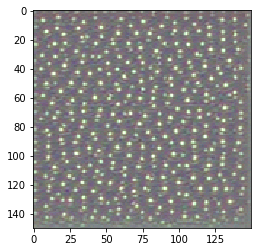

In [46]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])  # loss maximizes activation for chosen filter
    
    grads = K.gradients(loss, model.input)[0]  # computes gradient of input image
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])  # returns loss, grad given input image
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    steps = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

plt.imshow(generate_pattern('block3_conv1', 0))

We can now look at the first 64 filters for the first layer in each convolution block: `block1_conv1`, `block2_conv`, `block3_conv1`, `block4_conv1` and `block5_conv1`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


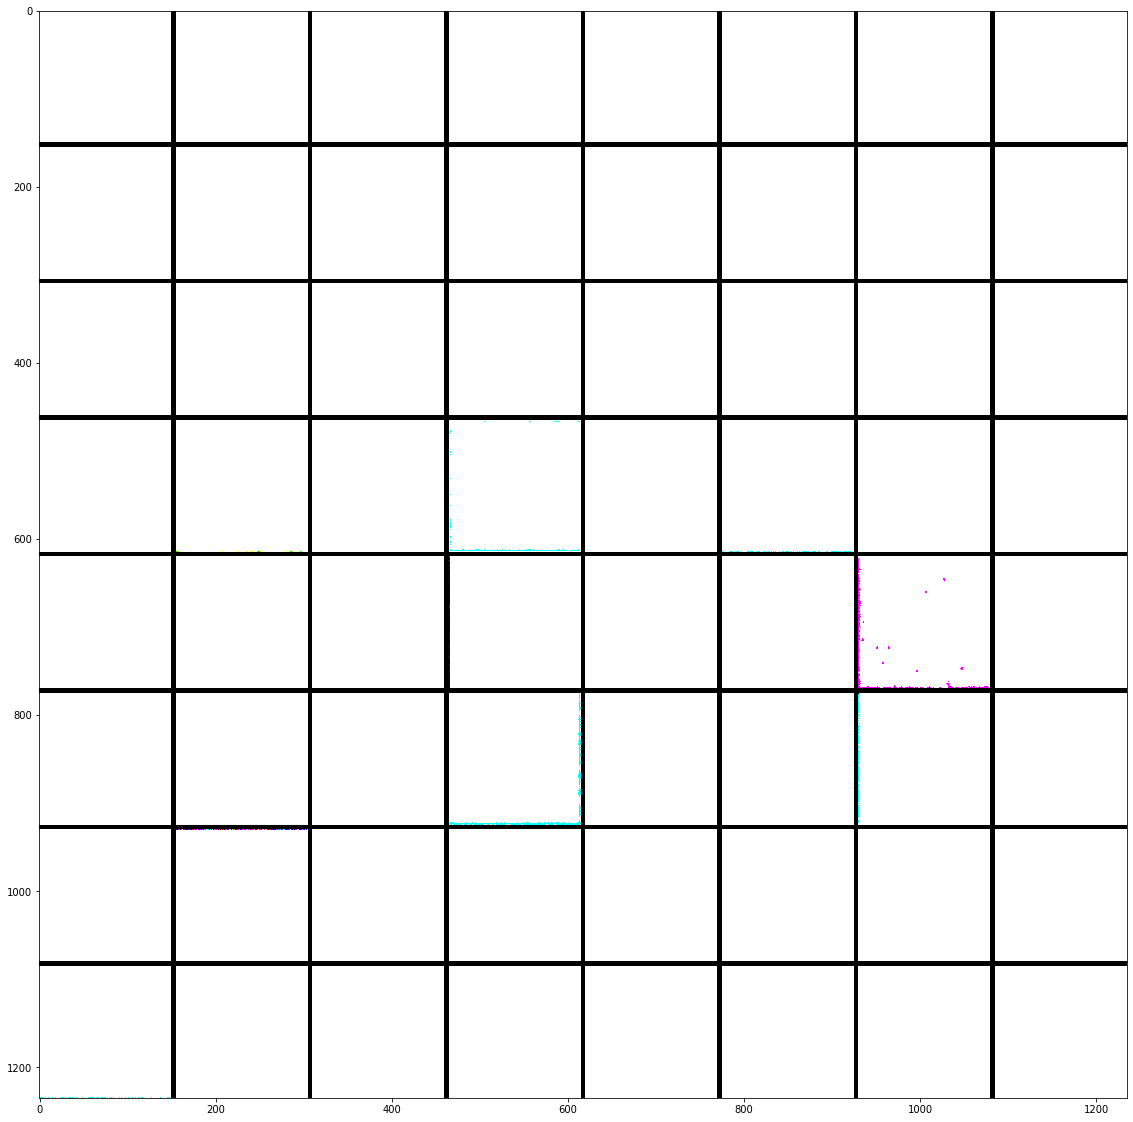

In [47]:
layer_names = ['block1_conv1']  #, 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
size = 150
margin = 5

for layer_name in layer_names:
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))  # empty image to store results

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
    plt.figure(figsize=(20, 20))
    plt.imshow(results)

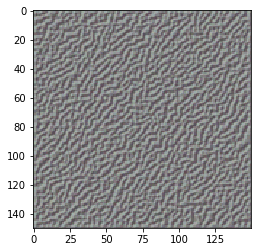

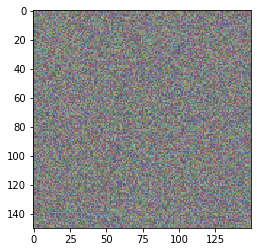

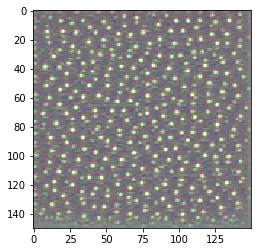

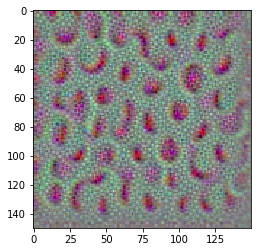

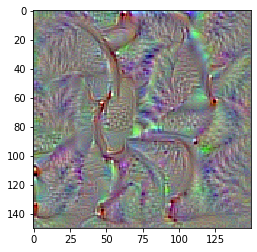

In [48]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

for name in layer_names:
    plt.figure()
    plt.imshow(generate_pattern(name, 0))

We see that the filters from the first layer encode simple directional edges. Th second layer encodes textures and the higher layers have higher features such as leaves and eyes.

## 7.3. Visualizing heatmaps of class activation
This is used to understand what parts of a given image led the network to its classification. This can be useful for understanding misbehaviour by the classifier. We can also locate specific objects in an image.

Class Activation Maps (CAMs) indicate how important each location is for the class under consideration. For example, we can look how cat-like different parts of the image are. It takes the output feature map of a convolution layer given an input image and weights every channel in that feature map by the gradient of the class with respect to the channel. That is it weights how intensely the input image activates different channels by how important each channel is with regard to the class.

In [50]:
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet')

img_path = base_dir + '/creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)  # numpy array (224, 224, 3)
x = np.expand_dims(x, axis=0)  # adds dimension so size is (1, 224, 224, 3)
x = preprocess_input(x)

Let us see the image.

(1, 600, 899, 3)


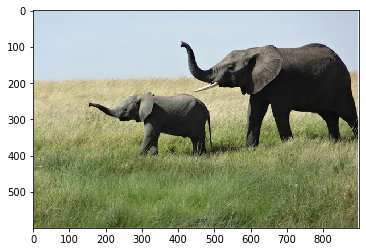

In [51]:
img_path = base_dir + '/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(600,899))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

plt.imshow(img_tensor[0])

We can then predict the class.

In [52]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])
print('Predicted class index:', np.argmax(preds[0]))

Predicted: [('n02504458', 'African_elephant', 0.8721392), ('n01871265', 'tusker', 0.11614813), ('n02504013', 'Indian_elephant', 0.011627928), ('n02408429', 'water_buffalo', 8.415691e-05), ('n02397096', 'warthog', 2.63688e-07)]
Predicted class index: 386


The class index with maximimum probability is 386.

We can visualize which parts of the image are the most elephant-like.

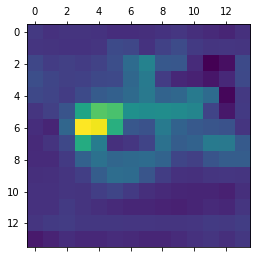

In [53]:
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')  # last convolutional layer in VGG16
# gradient of elephant class wrt to output feature map block5_conv3
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# vector of shape (512, ) where each entry is mean intensity of gradient over a specific feature-map channel
# note the last feature map has 512 channels
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])  # calcualte grad, output given input
# multiply each channel in feature map by how important the channel is to elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)  # channel-wise mean of resulting feature map
heamap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

Finally, we can use OpenCV to generate an image that superimposes the original image on the heatmap.

In [54]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # resizes heatmap to be same size as input
heatmap = np.uint8(255 * heatmap)  # converts heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # applies heatmap to original image
superimposed_img = heatmap * 0.4 + img

cv2.imwrite(base_dir + '/elephant_cam.jpg', superimposed_img)

True

We can then plot the written image.

(1, 600, 899, 3)


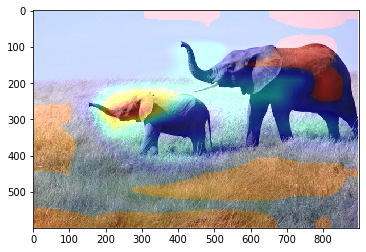

In [55]:
img_path = base_dir + '/elephant_cam.jpg'

img = image.load_img(img_path, target_size=(600,899))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

plt.imshow(img_tensor[0])